Epoch 0, Loss: 1.7241e+01
Epoch 1000, Loss: 4.9346e-01
Epoch 2000, Loss: 3.9489e-01
Epoch 3000, Loss: 3.5277e-01
Epoch 4000, Loss: 3.4215e-01
Epoch 5000, Loss: 3.1814e-01
Epoch 6000, Loss: 2.9674e-01
Epoch 7000, Loss: 1.8800e-01
Epoch 8000, Loss: 1.3839e-01
Epoch 9000, Loss: 1.0372e-01
Epoch 10000, Loss: 8.4128e-02
Epoch 11000, Loss: 6.3774e-02
Epoch 12000, Loss: 4.5727e-02
Epoch 13000, Loss: 2.3672e-02
Epoch 14000, Loss: 8.9075e-03
Epoch 15000, Loss: 5.6221e-03
Epoch 16000, Loss: 4.3545e-03
Epoch 17000, Loss: 2.3875e-03
Epoch 18000, Loss: 2.4999e-03
Epoch 19000, Loss: 2.7845e-03


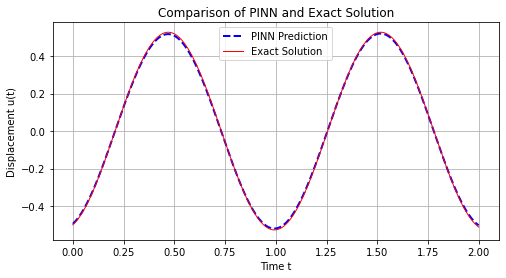

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Define the Physics-Informed Neural Network (PINN)
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 20),    # Input layer: time t (1 dimension)
            nn.Tanh(),           # Activation function
            nn.Linear(20, 20),   # Hidden layer
            nn.Tanh(),
            nn.Linear(20, 20),   # Hidden layer
            nn.Tanh(),
            nn.Linear(20, 1)     # Output layer: displacement u (1 dimension)
        )
    def forward(self, t):
        return self.net(t)

# Initialize model and optimizer
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training parameters
epochs = 20000  # Number of training epochs

# Training loop
for epoch in range(epochs):
    optimizer.zero_grad()
    
    # --- Initial condition loss ---
    t_initial = torch.zeros(1, requires_grad=True).float()  # t=0
    u_initial_pred = model(t_initial)  # Model prediction
    
    # Loss for u(0)
    loss_u = torch.mean((u_initial_pred + 0.5)**2)  # Initial condition u(0) = -0.5
    
    # Loss for u'(0)
    du_dt_initial = torch.autograd.grad(
        outputs=u_initial_pred,
        inputs=t_initial,
        grad_outputs=torch.ones_like(u_initial_pred),
        create_graph=True
    )[0]  # Compute first derivative
    loss_du = torch.mean((du_dt_initial - 1.0)**2)  # Initial condition u'(0) = 1
    
    # --- PDE residual loss ---
    # Sample collocation points in the domain
    t_collocation = torch.rand(1000, 1) * 2  # Time range [0, 2)
    t_collocation.requires_grad = True
    
    # Model prediction
    u = model(t_collocation)
    
    # Compute first derivative
    du_dt = torch.autograd.grad(
        outputs=u,
        inputs=t_collocation,
        grad_outputs=torch.ones_like(u),
        create_graph=True
    )[0]
    
    # Compute second derivative
    du2_dt2 = torch.autograd.grad(
        outputs=du_dt,
        inputs=t_collocation,
        grad_outputs=torch.ones_like(du_dt),
        create_graph=True
    )[0]
    
    # Residual: 0.5*u'' + 18u = 0
    residual = 0.5 * du2_dt2 + 18 * u
    loss_pde = torch.mean(residual**2)
    
    # Total loss
    total_loss = loss_u + loss_du + loss_pde
    
    # Backpropagation
    total_loss.backward()
    optimizer.step()
    
    # Print training progress
    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss: {total_loss.item():.4e}')
            
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
# Plot results
t_test = torch.linspace(0, 2, 1000).reshape(-1, 1)
u_pred = model(t_test).detach().numpy()

# Exact solution
u_exact = 0.52705 * np.cos(6 * t_test.numpy() - 2.81984)

plt.figure(figsize=(8, 4))
plt.plot(t_test, u_pred, 'b--', linewidth=2, label='PINN Prediction')
plt.plot(t_test, u_exact, 'r-', linewidth=1, label='Exact Solution')
plt.xlabel('Time t')
plt.ylabel('Displacement u(t)')
plt.legend()
plt.title('Comparison of PINN and Exact Solution')
plt.grid(True)
plt.show()

In [2]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
y_exact = u_exact.reshape(-1, 1)
y_p_pinn = u_pred
y_true = u_exact
R2_pinn = r2_score(y_p_pinn, y_true)
mae_pinn = mean_absolute_error(y_p_pinn, y_true)
rmse_pinn = mean_squared_error(y_p_pinn, y_true, squared=False)
inf_norm_pinn = np.linalg.norm(y_p_pinn - y_true, ord = np.inf)

print(f"R2_pinn: {R2_pinn}, mae_pinn: {mae_pinn}, rmse_pinn: {rmse_pinn}, inf_norm_pinn: {inf_norm_pinn}")

R2_pinn: 0.9997266693870861, mae_pinn: 0.005227585788816214, rmse_pinn: 0.00592146348208189, inf_norm_pinn: 0.01037299633026123


In [3]:
import numpy as np
import pandas as pd

data_to_save = pd.DataFrame({
    'x': t_test.flatten(),
    'y_pred_pinn': y_p_pinn.flatten(),
    'y_exact': y_true.flatten()
})

data_to_save.to_csv('pinn_08.csv', index=False)
print(" pinn_08.csv")

数据已保存至 pinn_08.csv
